# Cómo hacer Web Scraping con Python 
Web scraping es súper útil cuando la única manera de interactuar con los datos que necesitas es a través de una página web. Vamos a aprender cómo hacer web scraping usando las librerías [Selenium](https://selenium-python.readthedocs.io/) y 
[Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) de Python. Selenium te ayuda a escribir código en Python para automatizar tus interacciones con el navegador web mientras Beautiful Soup te ayuda a extraer datos del código HTML que produce la página web que contiene los datos que necesitas.

Nuestra meta is scrapear datos del [Fort Bend County Community Impact Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/75133e049f584ae8b51dc6cba740009a) que presenta los datos sobre el desarrollo del COVID-19 en el condado de Fort Bend County en Tejas. Vamos a extraer los datos históricos del número de pruebas realizadas y el número de casos diarios para estimar el porcentaje de casos positivos en el condado de Fort Bend.

Todos los códigos en este tutorial están escritos en Python 3.6.2.

## Paso 1 - Bajar Librerías, Módulos, y Métodos de Python 
El primer paso es bajar las librerías, módulos, y métodos de Python que necesitamos para hacer web scraping. Las versiones de las librerías usadas en este tutorial están detalladas a continuación.

| Librería | Versión | Descripción |
| --: | :--: | :-- |
| bs4        | 0.0.1  | Beautiful Soup se usa para extraer datos de archivos HTML.  |
| selenium   | 3.14.0 | Selenium se usa para automizar interacciones con el navegador web. |
| webdriver-manager | 3.2.1 | Webriver Manager facilita la gestión de binarios de diferentes navegadores. |
| pandas     | 0.20.3 | Pandas se usa para manejar datos. |
| numpy | 1.13.1 | NumPy se usa para facilitar cálculos. |
| matplotlib | 2.0.2  | Matplotlib se usa para visualizar datos. |


In [1]:
# Baja librerías para ...
## extraer datos de archivos HTML 
from bs4 import BeautifulSoup 

## automatizar interacciones con el navegador web
from selenium import webdriver # módulo que contiene implementaciones de controladores de navegadores web
from webdriver_manager.chrome import ChromeDriverManager # controlador de Chrome  
from selenium.webdriver.support import expected_conditions as EC # método para escribir códigos que esperan hasta que ciertas condiciones sean cumplidas
from selenium.webdriver.support.ui import WebDriverWait # método para escribir códigos que utilizan esperas implícitas o explícitas
from selenium.webdriver.common.by import By # método para localizar elementos por sus atributos HTML
from selenium.webdriver import ActionChains # módulo para implementar interacciones con el navegador 

## manejar datos
import pandas as pd
from datetime import datetime
import numpy as np

## visualizar datos
import matplotlib.pyplot as plt

## Paso 2 - Obtener el Código HTML 
El siguiente paso es escribir códigos de Python para automatizar nuestra interacción con la página web. Antes de empezar, necesitamos ir a la página web e inspeccionar su código fuente para identificar los elementos HTML que contienen los datos que necesitamos. El código fuente se refiere al código HTML que le dice a tu navegador cómo hacer la página web. Para ver el código fuente, ve a la página web y usa el método abreviado de teclado ``Ctrl+Shift+I``. Aparecerá una ventana interactiva con el código fuente de la página web.

Verás que solo aparecen los datos históricos del número de pruebas realizadas y el número de casos diarios cuando haces clic en la pestaña "History" de la ventana "Total Numbers of Tests Performed at County Sites" y la pestaña "Daily Case Count" de la ventana "Confirmed Cases", respectivamente. Esto significa que necesitamos escribir códigos de Python que automáticamente hacen clic en las pestañas "History" y "Daily Case Count" para que los datos históricos del número de pruebas realizadas y el número de casos diarios sean visibles para Beautiful Soup.
 

![](COVID_FB_files/dashboard-overview.png "Fort Bend County Community Impact Dashboard el 10 de julio 2020")

Para encontrar el elemento HTML que contiene la pestaña "History", usa el método abreviado de teclado ``Ctrl+Shift+C`` y haz clic en la pestaña "History". Verás en la ventana interactiva del código fuente que la pestaña "History" está en un elemento div con ID "ember208".


![](COVID_FB_files/history-html.png "Código Fuente de la Pestaña History")

Siguiendo los mismos pasos para la pestaña "Daily Case Count", verás que la pestaña "Daily Case Count" está en un elemento div con ID "ember238".

![](COVID_FB_files/daily-case-count-html.png "Código Fuente de la Pestaña Daily Case Count")


Ahora que hemos identificado los elementos que necesitamos, podemos escribir códigos que:
1. Inician la página web en Chrome
2. Hacen clic en la pestaña "History" cuando la pestaña "History" haya terminado de cargarse
3. Hacen clic en la pestaña "Daily Case Count" cuando la pestaña "Daily Case Count" haya terminado de cargarse
4. Extraen el código fuente HTML
5. Salen de Chrome

In [2]:
# Inicializa la página web en el navegador Chrome
driver = webdriver.Chrome(ChromeDriverManager().install())
url = 'https://www.arcgis.com/apps/opsdashboard/index.html#/75133e049f584ae8b51dc6cba740009a'
driver.get(url)

# Espera que termine de cargarse el elemento conteniendo los datos históricos de las pruebas realizadas
delay = 10
try:
    element_present = EC.presence_of_element_located((By.ID, 'ember208'))
    WebDriverWait(driver, delay).until(element_present)
except TimeoutException:
    print('Timed out waiting for page to load')

# Haz clic el la pestaña de los datos históricos de las pruebas realizadas 
element1 = driver.find_element_by_id("ember208")
ActionChains(driver).click(element1).perform()

# Espera que termine de cargarse el elemento conteniendo los datos históricos de los casos diarios
try:
    element_present = EC.presence_of_element_located((By.ID, 'ember238'))
    WebDriverWait(driver, delay).until(element_present)
except TimeoutException:
    print('Timed out waiting for page to load')

# Haz clic en la pestaña de los datos históricos de los casos diarios 
element2 = driver.find_element_by_id("ember238")
ActionChains(driver).click(element2).perform()

# Extrae y guarda el código fuente HTML
soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()

[WDM] - Current google-chrome version is 84.0.4147
[WDM] - Get LATEST driver version for 84.0.4147
[WDM] - Get LATEST driver version for 84.0.4147


[WDM] - Trying to download new driver from http://chromedriver.storage.googleapis.com/84.0.4147.30/chromedriver_win32.zip
[WDM] - Driver has been saved in cache [C:\Users\karla\.wdm\drivers\chromedriver\win32\84.0.4147.30]


# Paso 3 - Extraer Datos del Código HTML
Ahora, necesitamos extraer del código HTML los datos históricos del número de pruebas realizadas y el número de casos diarios. Empezaremos inspeccionando el código fuente de la página web para identificar los elementos HTML que contienen los datos.

Para encontrar el elemento div que contiene los datos históricos del número de pruebas realizadas, usa el método abreviado de teclado `Ctrl+Shift+C` y después haz clic en el área general del gráfico "Testing Sites". Verás en el código fuente que el gráfico está en el elemento div con ID "ember96".

![](COVID_FB_files/history-plot.png "Código Fuente del Gráfico Testing Sites")

Si colocas el cursor sobre cualquier dato en el gráfico, aparecerá una etiqueta con la fecha y el número de pruebas realizadas. Usa el método abreviado de teclado `Ctrl+Shift+C` y después haz clic en cualquier dato en el gráfico. Verás que el texto de la etiqueta está guardado en un atributo `aria-label` de un elemento `g`.

![](COVID_FB_files/history-label.png "Código Fuente de las Etiquetas del Gráfico Testing Sites")

Siguiendo los mismos pasos para los casos diarios, verás que el gráfico del número de casos diarios está en el elemento div con ID "ember143".

![](COVID_FB_files/daily-case-count-plot.png "Código Fuente del Gráfico Daily Cases based on Report Date")

Si colocas el cursor sobre cualquier dato en el gráfico, aparecerá una etiqueta con la fecha y el número de casos reportados. Usa el método abreviado de teclado `Ctrl+Shift+C` y verás que cada dato está guardado en el atributo `aria-label` de un elemento `g`.

![](COVID_FB_files/daily-case-count-label.png "Código Fuente del las Etiquetas del Gráfico Daily Cases based on Report Date")

Cuando hayamos identificado todos los elementos que contienen los datos, podemos escribir códigos que:
1. Encuentran el elemento div que contiene el gráfico del número de pruebas realizadas y extraen los datos del número de pruebas realizadas
2. Encuentran el elemento div que contiene el gráfico del número de casos diarios y extraen los datos del número de casos diarios
3. Combina los datos en un dataframe de pandas y lo exporta a un CSV

In [19]:
# Obten el elemento <div> que contiene los datos del número de pruebas realizadas
elements_total_tests = soup.findAll('div', {'id': 'ember96'})[0].findAll('g')

# Extrae los datos del número de pruebas realizadas
total_tests = {'Date': [], 'Total_Tests': []}
for element in elements_total_tests:
    try:
        split_element = element['aria-label'].split()
        total_tests['Total_Tests'].append( int(split_element[-1].replace(',', '')) )
        total_tests['Date'].append( ' '.join(split_element[4:7]) )
    except:
        pass

# Obten el elemento <div> que contiene los datos del número de casos diarios
elements_total_positive_cases = soup.findAll('div', {'id': 'ember143'})[0].findAll('g')

# Extrae los datos del número de casos diarios
total_positive_cases = {'Date': [], 'Total_Cases': []}
for element in elements_total_positive_cases:
    try:
        split_element = element['aria-label'].split()
        total_positive_cases['Total_Cases'].append( int(split_element[-1].replace(',', '')) )
        total_positive_cases['Date'].append( ' '.join(split_element[2:5]) )
    except:
        pass
    
# Convierte el diccionario a un dataframe de pandas
total_tests_df = pd.DataFrame.from_dict(total_tests)
total_positive_cases_df = pd.DataFrame.from_dict(total_positive_cases)

# Corrige el formato de las fechas
total_tests_df['Date'] = pd.to_datetime(total_tests_df['Date'], format='%b %d, %Y')
total_tests_df.set_index('Date', inplace=True)
total_positive_cases_df['Date'] = pd.to_datetime(total_positive_cases_df['Date'], format='%b %d, %Y')
total_positive_cases_df.set_index('Date', inplace=True)

# Combina los datos y guardalos en un archivo CSV
data = total_tests_df.join(total_positive_cases_df, how='outer').reset_index()
data.to_csv('covid_fortbend.csv', index=False)

## Paso 4 - Calcula la Tasa de Positividad
Finalmente, podemos estimar la tasa de positividad de COVID-19 en el condado de Fort Bend. Vamos a dividir el número de casos por el número de pruebas realizadas y después vamos a obtener la media móvil de siete días del resultado. La información visualizada en el tablero de datos no permite ver con claridad si los casos diarios reportados incluyen casos que no fueron identificados a través de pruebas llevadas a cabo por el condado (e.g., pruebas realizadas en hospitales o clínicas). Tampoco está claro cuál es la fecha en que se realizaron las pruebas de los casos positivos porque el tablero de datos solamente presenta los casos en el día que fueron reportados en vez del día en que se hicieron la prueba. Por estas razones, las tasas de positividad derivadas de estos datos solamente son aproximaciones de la verdadera tasa de positividad.

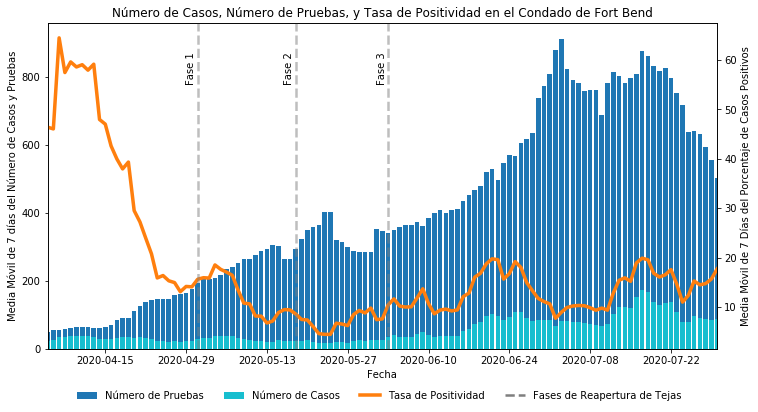

In [20]:
# Solamente incluye datos desde el 30 de marzo 2020 hasta el presente porque el condado 
# empezó a ofrecer pruebas gratuitas al público empezando el 30 de marzo 2020 
data = data.loc[data.Date >= '2020-03-30'].reset_index(drop=True)

# Reemplaza NaNs con 0s (la mayoría de NaNs ocurren en los domingos y los centros de 
# pruebas están cerrados los domingos)
data.fillna(0, inplace=True) 

# Convierte la columna Date a la columna índice
data.set_index('Date', inplace=True)

# Revisa si hay fechas que falten
missing_dates = pd.date_range(start='2020-03-30', end=max(data.index)).difference(data.index)
for dt_index in missing_dates:
    data.loc[dt_index] = [0, 0]
data = data.loc[data.index.sort_values()] # Asegura que se preserve el orden crónologico 

# Calcula la tasa de positividad
data['Positivity_Ratio'] = 100 * data['Total_Cases'].rolling(window=7).sum() / data['Total_Tests'].rolling(window=7).sum()
data.replace([np.inf, -np.inf], 0, inplace=True)

# Haz el gráfico del número de casos, pruebas, y tasa de positividad
fig = plt.figure(figsize=(12,6))
barchart1 = plt.bar(data.index, data['Total_Tests'].rolling(window=7).mean(), color='tab:blue')
barchart2 = plt.bar(data.index, data['Total_Cases'].rolling(window=7).mean(), color='tab:cyan')
plt.xlabel('Fecha')
plt.ylabel('Media Móvil de 7 días del Número de Casos y Pruebas')
plt.twinx()
linechart = plt.plot(data.index, data['Positivity_Ratio'], color='tab:orange', linewidth=3.5)
plt.title('Número de Casos, Número de Pruebas, y Tasa de Positividad en el Condado de Fort Bend')
plt.ylabel('Media Móvil de 7 Días del Porcentaje de Casos Positivos')
plt.xlim(data.loc[~data.isnull().any(axis=1)].index[0], data.loc[~data.isnull().any(axis=1)].index[-1])

# Indica las fechas de las fases de reapertura de Tejas
phase1_dt = '2020-05-01'
phase2_dt = '2020-05-18'
phase3_dt = '2020-06-03'
plt.axvline(x=phase1_dt, linewidth=2.5, linestyle='--', color='tab:gray', alpha=0.5)
plt.axvline(x=phase2_dt, linewidth=2.5, linestyle='--', color='tab:gray', alpha=0.5)
plt.axvline(x=phase3_dt, linewidth=2.5, linestyle='--', color='tab:gray', alpha=0.5)
plt.text('2020-04-29', 60,'Fase 1', rotation=90)
plt.text('2020-05-16', 60,'Fase 2', rotation=90)
plt.text('2020-06-01', 60,'Fase 3', rotation=90)

# Incluye leyenda
orange_line = plt.Line2D([], [], color='tab:orange', linewidth=3.5)
gray_line = plt.Line2D([], [], color='tab:gray', linewidth=2.5, linestyle='--')
plt.legend((barchart1, barchart2, orange_line, gray_line), 
           ('Número de Pruebas', 'Número de Casos', 'Tasa de Positividad', 'Fases de Reapertura de Tejas'), 
           ncol=4, bbox_to_anchor=(0.96, -0.1), frameon=False)
plt.show()

## Fuentes
1. https://www.fbchealth.org/ncov/
2. https://www.fortbendcountytx.gov/your-county/fort-bend-county-expands-covid-19-testing-site-to-all-residents
3. https://gov.texas.gov/news/post/governor-abbott-announces-phase-one-to-open-texas-establishes-statewide-minimum-standard-health-protocols
4. https://gov.texas.gov/news/post/governor-abbott-announces-phase-two-to-open-texas
5. https://gov.texas.gov/news/post/governor-abbott-announces-phase-iii-to-open-texas